In [0]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [0]:
##En orden de ejecutar el trabajo, es indispensable que la carpeta "Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final",
##que se adjunta con éste archivo, debe ser agregada a Mi Unidad en su propio drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

TensorFlow is already loaded. Please restart the runtime to change versions.


Using TensorFlow backend.


In [0]:
filenames = []
for filename in glob.glob("/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/*"):
    filenames.append(filename)

In [0]:
filenames.sort()
#print (filenames)

['/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_1995.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_1996.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_1997.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_1998.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_1999.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_2000.xlsx', '/content/drive/My Drive/Redes Neuronales y Algoritmos Bioinspirados - Trabajo Final/datos/precios/Precio_Bolsa_Nacional_($kwh)_2001.xlsx', '/content/drive/My 

In [0]:
final = pd.read_excel(filenames[0], skiprows = 3)
for i in range(1,len(filenames)):    
    c = 0    
    while(True):         
        initial = pd.read_excel(filenames[i],skiprows = c).iloc[:,0:25]          
        if initial.columns[0] == 'Fecha':
            break
        elif c >= 15:
            break
        else:
            c+=1
    final = pd.concat([final,initial],ignore_index=True,axis=0)
final["Fecha"] = pd.to_datetime(final["Fecha"])
final = final.sort_values(by=['Fecha'])
serie = pd.concat([final["Fecha"],final.mean(axis=1)],axis=1)

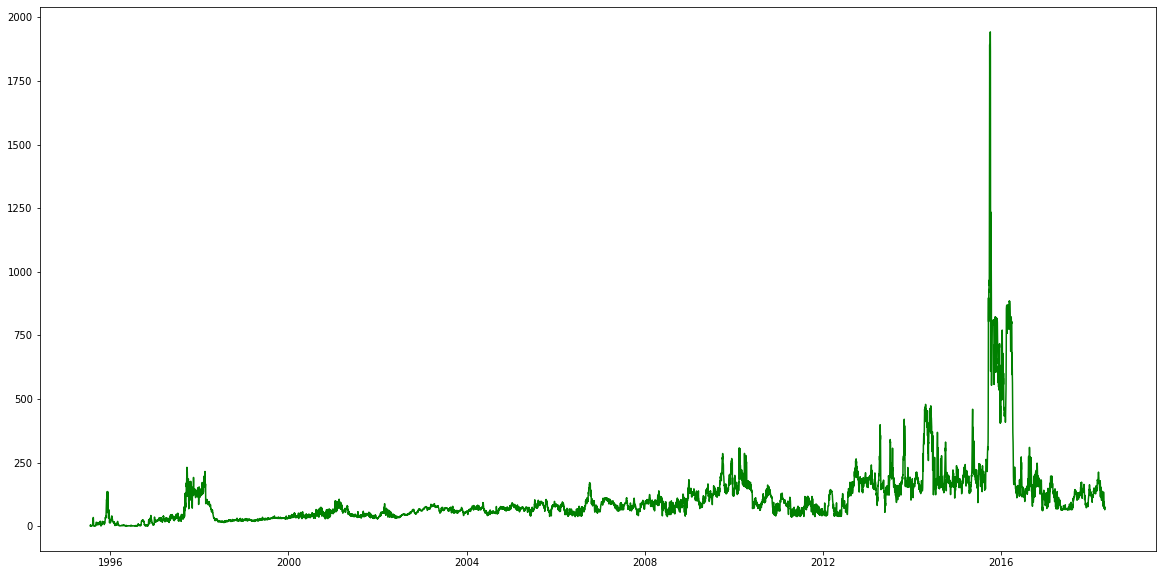

In [0]:
figure(num=None, figsize=(20,10))
plt.plot(serie["Fecha"], serie.iloc[:,1],'g-')
plt.show()

In [0]:
serie = serie.dropna()
serie = serie.reset_index(drop=True)
serie.columns = ["Fecha","Precio"]

In [0]:
##Se normaliza la serie
sc = MinMaxScaler(feature_range = (0, 1))
d = sc.fit_transform(serie["Precio"].values.reshape(-1,1)).reshape(-1,)

In [0]:
##Modelo Adaline
predict_days = 24*7
tf.executing_eagerly()

True

In [0]:
class Model(object):
    def __init__(self, L):      
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

In [0]:
##Se hallará el número óptimo de retardos
delays = [2,3,4,5,6,7,8,10]
def imp_delays(delays,d):
    results = []
    for i in range(len(delays)):
        L = delays[i]
        model = Model(L)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])
        resultsd.append([d[-(predict_days):],y_pred[-(predict_days):]]) 
    return resultsd

resultsd = imp_delays(delays,d)
best_delays = []
for i in resultsd:
    best_delays.append(metrics.mean_squared_error(i[0],i[1]))

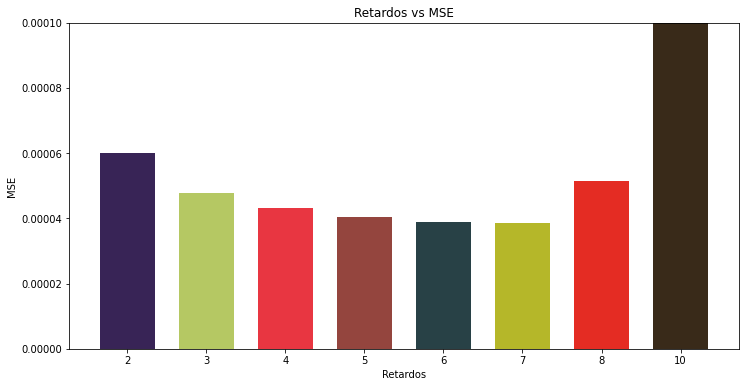

In [0]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(["2","3","4","5","6","7","8","10"],[best_delays[0], best_delays[1], best_delays[2], best_delays[3], best_delays[4], best_delays[5], 
        best_delays[6], best_delays[7]], width=0.7, alpha=0.9, color=['#220C43','#ADC252','#E6202C','#893129','#102C32','#ADB012','#E2150B','#231300'])
plt.ylim(0,0.00010)
plt.xlabel("Retardos")
plt.ylabel("MSE")
ax.set_title('Retardos vs MSE')
plt.show()

In [0]:
##Se hallará los valores óptimos de la tasa de aprendizaje óptima
lrates = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]
def imp_lrates(lr,d):  
    resultsl = []
    for i in range(len(lr)):    
        L = 6
        model = Model(L)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])
        resultsl.append([d[-(predict_days):],y_pred[-(predict_days):]])
    return resultsl

resultsl = imp_lrates(lrates,d)
best_lrates = []
for i in resultsl:
    best_lrates.append(metrics.mean_squared_error(i[0],i[1]))

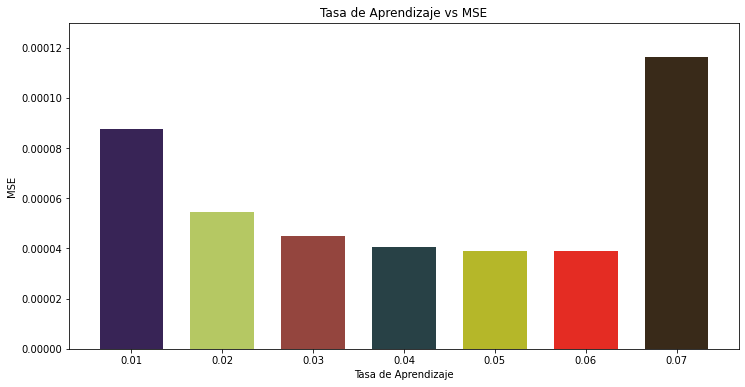

In [0]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(["0.01","0.02","0.03","0.04","0.05","0.06","0.07"],[best_lrates[0], best_lrates[1], best_lrates[2], best_lrates[3], best_lrates[4],
        best_lrates[5], best_lrates[6]], width=0.7, alpha=0.9, color=['#220C43','#ADC252','#893129','#102C32','#ADB012','#E2150B','#231300'])
plt.ylim(0,0.00013)
plt.xlabel("Tasa de Aprendizaje")
plt.ylabel("MSE")
ax.set_title('Tasa de Aprendizaje vs MSE')
plt.show()

In [0]:
##Adaline con parametros óptimos
def adaline(L,lr,d):
    L = L
    model = Model(L)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan
    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])
    return [d[-(predict_days):],y_pred[-(predict_days):]]
    
model_nt = adaline(7,0.05,d)

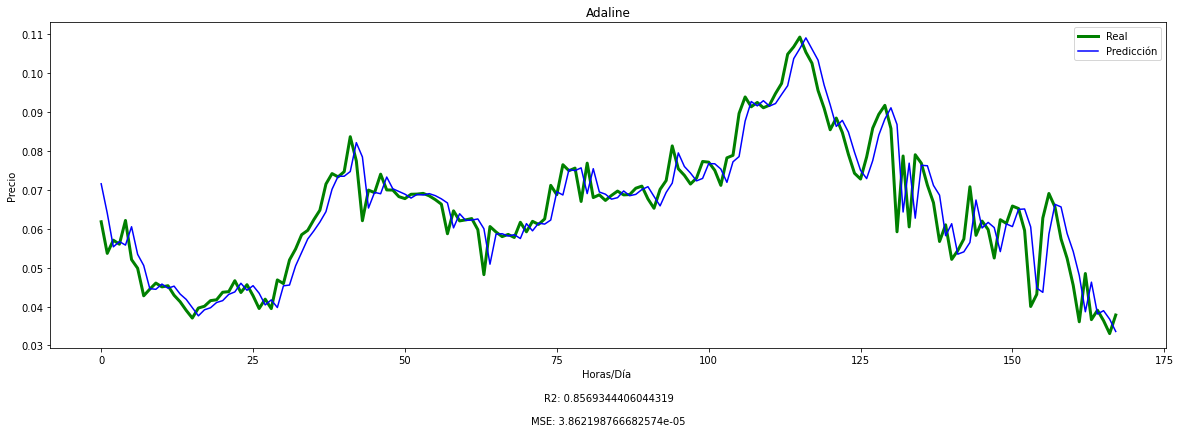

In [0]:
def graph_model(real,pred,name):
    figure(figsize=(20,6))
    plt.plot(real, color = 'green', label = 'Real',linewidth= 3)
    plt.plot(pred, color = 'blue', label = 'Predicción')
    plt.title(name)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()


graph_model(model_nt[0],model_nt[1],"Adaline")

In [0]:
def eval(results,parameters):  
    metricsx = []
    
    for i in range(len(results)):
        
        real,pred = results[i][0],results[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricsx.append([r2,mse])
     
    df = pd.DataFrame(metricsx,parameters)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

In [0]:
##Raíz cuadrada
serie_sqrt = sc.fit_transform(serie["Precio"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)

0    0.849737
1    0.000163
Name: 5, dtype: float64

In [0]:
results_delay_sqrt = imp_delays(delays,serie_sqrt)
best_delay_sqrt = eval(results_delay_sqrt,delays)
best_delay_sqrt

In [0]:
results_lrates_sqrt = imp_lrates(lrates,serie_sqrt)
best_lrates_sqrt = eval(results_lrates_sqrt,lrates)
best_lrates_sqrt

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

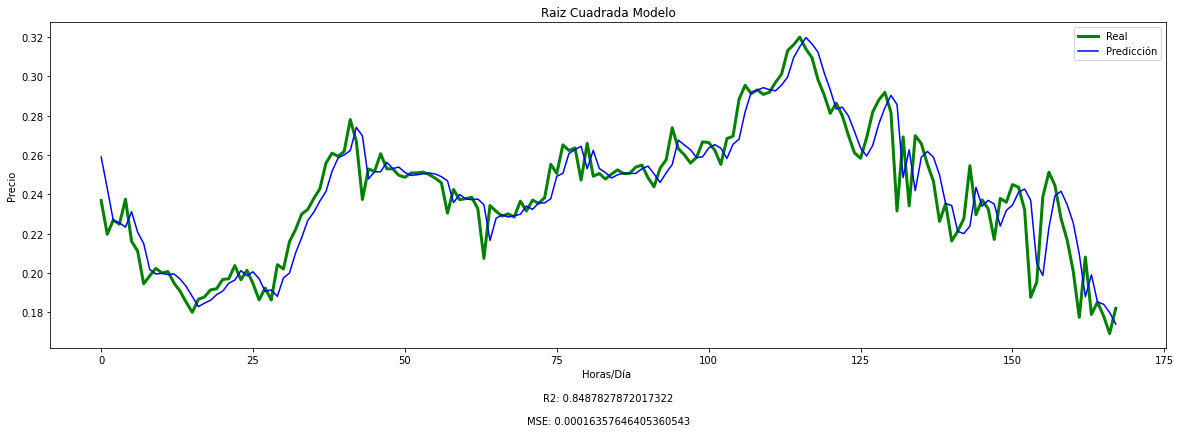

In [0]:
model_sqrt = adaline(5,0.04,serie_sqrt)
graph_model(model_sqrt[0],model_sqrt[1],"Raiz Cuadrada Modelo")

In [0]:
##Logaritmo Natural
serie_log = sc.fit_transform(np.array(serie["Precio"].apply(np.log).values).reshape(-1,1)).reshape(-1,)

In [0]:
results_delays_log = imp_delays(delays,serie_log)
best_delay_log = eval(results_delays_log[:-3],delays[:-3])
best_delay_log

0    0.847960
1    0.000151
Name: 2, dtype: float64

In [0]:
results_lrates_log = imp_lrates(lrates,serie_log)
best_lrate_log = eval(results_lrates_log[:-2],lrates[:-2])
best_lrate_log

0    0.844496
1    0.000154
Name: 0.02, dtype: float64

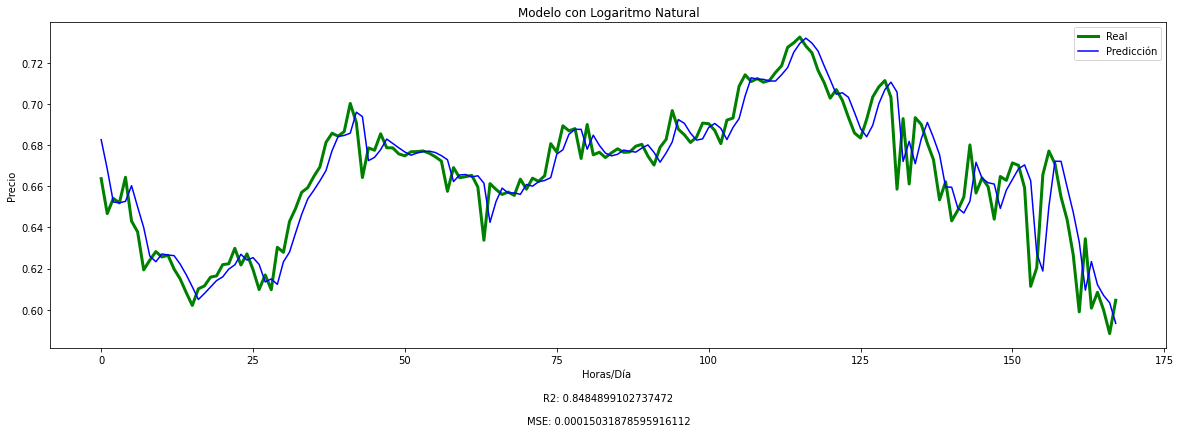

In [0]:
modelo_log = adaline(2,0.04,serie_log)
graph_model(modelo_log[0],modelo_log[1],"Modelo con Logaritmo Natural")

Como se puede apreciar, ninguna de las transformaciones genera un cambio significativo en el modelo, por lo que se recomienda no aplicar ninguna transformación.